In [1]:
import sys

In [2]:
import torch

In [3]:
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModel, AutoTokenizer 

In [4]:
import os

In [5]:
import pandas as pd

In [6]:
import dask.dataframe as dd

In [7]:
import numpy as np

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string

# Load Data

In [13]:
examples_path = os.path.join('.', 'data', 'shopping_queries_dataset_examples.parquet')
products_path = os.path.join('.', 'data', 'shopping_queries_dataset_products.parquet')
sources_path = os.path.join('.', 'data', 'shopping_queries_dataset_sources.csv')

examples = dd.read_parquet(examples_path)
products = dd.read_parquet(products_path)
sources = dd.read_csv(sources_path)

In [14]:
examples_products = dd.merge(
    examples,
    products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

examples_products = examples_products[examples_products['product_locale'] == 'us']

task_2 = examples_products[examples_products['large_version'] == 1]

# removing puncuation 
# this takes in the dask data frame and the string puncuation 
# applied to the daskdata frame
# lambda which processes each test in the dask series 
# it iterates through each character and saves only characters that are not in puncts

puncts = string.punctuation
def process_text(text_series, puncts):
    return text_series.apply(lambda text: ''.join(ch for ch in str(text) if ch not in puncts))


task_2['query'] = task_2['query'].map_partitions(process_text, puncts=puncts)


# encoding the esci labels 
label_mapping = {'E': 0, 
                 'S': 1, 
                 'C': 2, 
                 'I': 3}

task_2['encoded_labels'] = task_2['esci_label'].map(label_mapping).astype(int)



task_2_train = task_2[task_2['split'] == 'train']
task_2_test = task_2[task_2['split'] == 'test']

/home/cgcordes/python3.14/lib/python3.11/site-packages/dask_expr/_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('esci_label', 'float64'))

  warnings.warn(meta_warning(meta))


In [12]:
# Sample data for proof of concept 
# delete later 
data = {'query': ["!qscreen fence without holes", "#1 black natural hair dye without ammonia or peroxide", 
                  "$100 things that are not electronics", "%100 silicone not clear", "&#34;tortillas without interesterified soybean oilâ€"]}

# create the fake data frame 
df = dd.from_pandas(pd.DataFrame(data), npartitions=1)

# applying to the 'query' column using map_partitions
df['query'] = df['query'].map_partitions(process_text, puncts=puncts)

pd.set_option('display.max_colwidth', None)

print(df.compute())

                                                  query
0                           qscreen fence without holes
1  1 black natural hair dye without ammonia or peroxide
2                   100 things that are not electronics
3                                100 silicone not clear
4    34tortillas without interesterified soybean oilâ€


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
model = AutoModel.from_pretrained('distilroberta-base').to(device)

for param in model.parameters():
    param.requires_grad = False

def generate_embeddings(texts):
    batch_size = 128  # adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # Expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [17]:
# creating a data frame and enerate column names
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

In [18]:
def generate_embeddings(texts):
    batch_size = 128  # adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # change for maxpooling (dim=1)
        pooled_embeddings = torch.max(outputs.last_hidden_state, dim=1).values
        batch_embeddings = pooled_embeddings.cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # Expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result


# Sampling the Data (Ignore when looking at full set) 

In [14]:
# computes the total number of rows in the df
total_rows = task_2_train.shape[0].compute()

# calculates the fraction of rows needed to sample 10000 
sample_fraction = 10000 / total_rows

# samples a fraction of the df 
task_2_train_sample = task_2_train.sample(frac=sample_fraction, random_state=42)

In [16]:
# replicating the same as above but with the test data 
# computes the total number of rows in the df
total_rows2 = task_2_test.shape[0].compute()

# calculates the fraction of rows needed to sample 
sample_fraction2 = 10000 / total_rows2

# samples a fraction of the df 
task_2_test_sample = task_2_test.sample(frac=sample_fraction2, random_state=42)

# Computing the Embeddings (Ignore after reading to CSV/NUMPY) 

In [19]:
# Computing the Embeddings for Train Data 
result = task_2_train.map_partitions(process_partition, meta=meta)
result = result.compute()

Combined shape: (1393063, 1536)


In [42]:
# Read it to a CSV 
result.to_csv('result_train_distilroberta_nopunct.csv')

In [24]:
# Read it to a NUMPY 
result_array = result.to_numpy()
np.save('result_train_distilroberta.npy', result_array)

In [20]:
# Computing the Embeddings for the Test Data
result2 = task_2_test.map_partitions(process_partition, meta=meta)
result2 = result2.compute()

Combined shape: (425762, 1536)


In [43]:
# Read it to a CSV 
result2.to_csv('result_test_distilroberta_nopunct.csv')

In [19]:
# Read it to a NUMPY 
result2_array = result2.to_numpy()
np.save('result_test_distilroberta.npy', result2_array)

# Importing Embeddings and Checking Structure 

In [21]:
# renaming since not reading back in the data
result_train = result
result_test = result2

In [16]:
# Read in the pre-saved data 
# This will take a little bit 
result_train = pd.read_csv('result_train_distilroberta.csv', index_col=0)
result_test = pd.read_csv('result_test_distilroberta.csv', index_col=0)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [22]:
print(result_train.head())

   embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0      0.12433     0.127676     0.085034     0.039097     0.297458   
1      0.12433     0.127676     0.085034     0.039097     0.297458   
2      0.12433     0.127676     0.085034     0.039097     0.297458   
3      0.12433     0.127676     0.085034     0.039097     0.297458   
4      0.12433     0.127676     0.085034     0.039097     0.297458   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
1     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
2     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
3     0.201057     0.026599     0.275267     0.080479     0.023758  ...   
4     0.201057     0.026599     0.275267     0.080479     0.023758  ...   

   embedding_1526  embedding_1527  embedding_1528  embedding_1529  \
0        0.419537        0.067311        0.201484        0.

In [23]:
print(result_test.head())

    embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
32    -0.010883     0.190984     0.055915    -0.007884     0.761822   
33    -0.010883     0.190984     0.055915    -0.007884     0.761822   
34    -0.010883     0.190984     0.055915    -0.007884     0.761822   
35    -0.010883     0.190984     0.055915    -0.007884     0.761822   
36    -0.010883     0.190984     0.055915    -0.007884     0.761822   

    embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
32    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
33    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
34    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
35    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   
36    -0.056676     0.139391     0.148942     0.076152     0.198935  ...   

    embedding_1526  embedding_1527  embedding_1528  embedding_1529  \
32        0.324944        0.216839        0.45

In [ ]:
# Read it in as a numpy array 
# result = np.load('result_train_distilroberta.npy')
# result2 = np.load('result_test_distilroberta.npy')

In [24]:
# Converting from DASK to Pandas 
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [25]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# Creating the Multi-Layer Preceptron Model

In [26]:
# mlp with maxpooling 
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        # flatten the input 
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = x.unsqueeze(1)
        x = self.pool(x)  
        # flatten the pooled output 
        x = x.view(x.size(0), -1) 
        # apply the 10% dropout 
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [27]:
# Inputting the Parameters

# Size of the concatenated embeddings(768 + 768)
input_size = 1536  
hidden_size = 128
# number of classes Exact, Substitute, Complement, Irrelevant (4)
num_classes = 4 

# initialize the model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# for the training hyperparameter configuration 
# Adam Optimizer with parameters: epsilon (1e-8), learning rate (5e-5) and weight decay (0.01)
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)


# Data Loading 

## Labeling Indicies

In [28]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [29]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [30]:
# not needed if not sampling 
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [31]:
# checking the training labels 
print(subset_labels)

         encoded_labels
0                     3
1                     0
2                     0
3                     0
4                     0
...                 ...
1818820               3
1818821               0
1818822               0
1818823               3
1818824               0

[1393063 rows x 1 columns]


In [32]:
# checking the test labels 
print(subset_labels2)

         encoded_labels
32                    3
33                    3
34                    0
35                    1
36                    1
...                 ...
1818788               0
1818789               3
1818790               3
1818791               3
1818792               0

[425762 rows x 1 columns]


In [33]:
class ESCIDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.values
        # this should be (size, 1563)
        print("Shape of embeddings:", self.embeddings.shape)
        self.labels = labels   

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (1393063, 1536)


In [34]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


In [35]:
# these should be the same length 
print("Length of embeddings:", len(train_dataset.embeddings))
print("Length of labels:", len(train_dataset.labels))

Length of embeddings: 1393063
Length of labels: 1393063


In [36]:
# these should both be 'numpy.ndarray' or theres a problem 
print("Type of embeddings:", type(train_dataset.embeddings))
print("Type of labels:", type(train_dataset.labels))

Type of embeddings: <class 'numpy.ndarray'>
Type of labels: <class 'numpy.ndarray'>


In [37]:
# look at the samples to double check everything is looking right 
for i in range(5):  
    embedding, label = train_dataset[i]
    print(f"sample {i} - embedding: {embedding}, label: {label}")

sample 0 - embedding: [0.12432991 0.12767594 0.08503409 ... 0.33728772 0.21012834 0.26508397], label: 3
sample 1 - embedding: [0.12432991 0.12767594 0.08503409 ... 0.48584455 0.24631253 0.19101998], label: 0
sample 2 - embedding: [0.12432991 0.12767594 0.08503409 ... 0.47372347 0.21870442 0.20419931], label: 0
sample 3 - embedding: [0.12432991 0.12767594 0.08503409 ... 0.61399883 0.32040575 0.19349714], label: 0
sample 4 - embedding: [0.12432991 0.12767594 0.08503409 ... 0.2160977  0.32783297 0.24916403], label: 0


In [38]:
# training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(embeddings.float()) 
            # converting the labels to long 
            labels = labels.long()
            # calculate the loss 
            loss = criterion(outputs, labels) 
            # backpropogation 
            loss.backward() 
            # updating the weights 
            optimizer.step()  

            # add up the loss 
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)


Epoch 1/4, Loss: 0.8365
Epoch 2/4, Loss: 0.8317
Epoch 3/4, Loss: 0.8310
Epoch 4/4, Loss: 0.8307


In [39]:
# evaluation and output the f1 score 
def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # needed to change this to floats 
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [40]:
# evaluating the model
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6514


# Finding Mismatches

In [45]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    # added test to make the confusion matrix 
    return test_df, mismatch_df

test_df, mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_205295/994583322.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_205295/994583322.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [85]:
# count top 10 mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            65
apple earbuds                              60
firestick                                  56
airpods 2                                  53
dek pro                                    48
futon frames full size without mattress    48
kindle                                     46
keep grinding hat                          42
marvel against humanity game               42
shaggy dog board game                      42
Name: count, dtype: int64[pyarrow]

Top 10 most common words in mismatched entries:
 [('for', 66849), ('-', 45241), ('with', 39985), ('and', 38192), ('&', 19424), ('of', 15107), ('|', 11940), ('Black', 11808), ('without', 10697), ('to', 9763)]


# Making a Confusion Matrix

In [46]:
print(test_df.head())

                          query  \
32  qscreen fence without holes   
33  qscreen fence without holes   
34  qscreen fence without holes   
35  qscreen fence without holes   
36  qscreen fence without holes   

                                                                                                                                                                      product_title  \
32                    FOTMISHU 6Pcs Greenhouse Hoops Rust-Free Grow Tunnel Tunnel, 4ft Long Steel with Plastic Coated Plant Supports for Garden Fabric, Plant Support Garden Stakes   
33                                                                                      Zippity Outdoor Products ZP19028 Unassembled Madison Vinyl Gate Kit with Fence Wings, White   
34                                                                  Zippity Outdoor Products ZP19026 Lightweight Portable Vinyl Picket Fence Kit w/Metal Base(42" H x 92" W), White   
35  ColourTree 4' x 50' Green Fence Privacy Screen Windsc

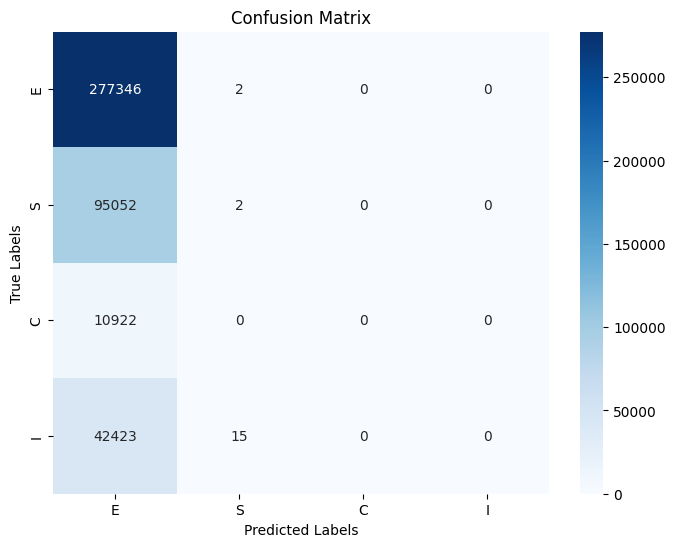

In [47]:
# make the confusion matrix
true_labels = test_df['true_label']
predicted_labels = test_df['predicted_label']

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'S', 'C', 'I'], yticklabels=['E', 'S', 'C', 'I'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


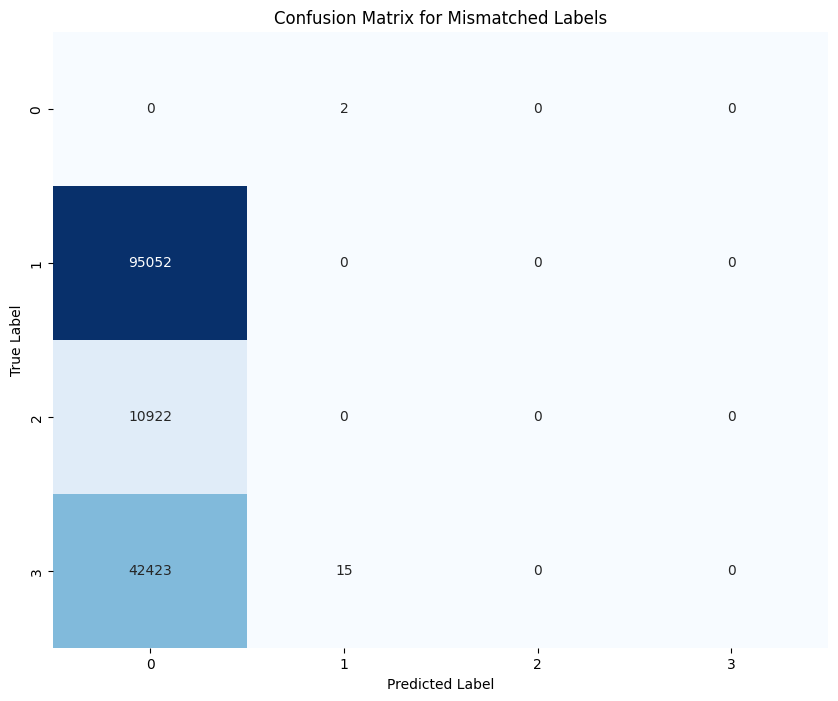

In [48]:
conf_matrix = confusion_matrix(mismatch_df['true_label'], mismatch_df['predicted_label'])

labels = sorted(mismatch_df['true_label'].unique())  
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Mismatched Labels')
plt.show()

# Using the alldistillroberta-v1

In [17]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-distilroberta-v1')
model = AutoModel.from_pretrained('sentence-transformers/all-distilroberta-v1').to(device)

for param in model.parameters():
    param.requires_grad = False

def generate_embeddings(texts):
    batch_size = 128  # adjust this size
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def process_partition(partition):
    query_embeddings = generate_embeddings(partition['query'])
    product_title_embeddings = generate_embeddings(partition['product_title'])

    combined = torch.cat((torch.tensor(query_embeddings), torch.tensor(product_title_embeddings)), dim=1).numpy()
    
    print(f'Combined shape: {combined.shape}')  # Expecting (n, 1536)

    result = pd.DataFrame(combined, index=partition.index, columns=[f'embedding_{i}' for i in range(combined.shape[1])])

    return result

In [18]:
# creating a data frame and enerate column names
meta = pd.DataFrame(columns=[f'embedding_{i}' for i in range(2 * 768)], dtype='float64')

# Ignore once embeddings are created 

In [42]:
# Computing the Embeddings for Train Data 
# result = task_2_train.map_partitions(process_partition, meta=meta)
# result = result.compute()

In [17]:
# Read it to a CSV 
result.to_csv('result_train_all-distilroberta-v1.csv')

In [18]:
# Read it to a NUMPY 
result_array = result.to_numpy()
np.save('result_train_all-distilroberta-v1.npy', result_array)

In [19]:
# Computing the Embeddings for the Test Data
result2 = task_2_test.map_partitions(process_partition, meta=meta)
result2 = result2.compute()

Combined shape: (425762, 1536)


In [20]:
# Read it to a CSV 
result2.to_csv('result_test_all-distilroberta-v1.csv')

In [21]:
# Read it to a NUMPY 
result2_array = result2.to_numpy()
np.save('result_test_all-distilroberta-v1.npy', result2_array)

# Data loading the all-distilroberta Data

In [19]:
# read in the train and test 
result_train = pd.read_csv('result_train_all-distilroberta-v1.csv', index_col=0)
result_test = pd.read_csv('result_test_all-distilroberta-v1.csv', index_col=0)

In [20]:
# Converting from DASK to Pandas 
task_2_train = task_2_train.compute()
task_2_test = task_2_test.compute()

In [21]:
# this should all be the same: pandas.core.frame.DataFrame
print(type(task_2_train))
print(type(task_2_test))
print(type(result_train))
print(type(result_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# Establishing the MLP

In [22]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        # flatten the input 
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = self.relu(x)
        x = x.unsqueeze(1)
        x = self.pool(x)  
        # flatten the pooled output 
        x = x.view(x.size(0), -1) 
        # apply the 10% dropout 
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [23]:
# Inputting the Parameters

# Size of the concatenated embeddings(768 + 768)
input_size = 1536  
hidden_size = 128
# number of classes Exact, Substitute, Complement, Irrelevant (4)
num_classes = 4 

# initialize the model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# for the training hyperparameter configuration 
# Adam Optimizer with parameters: epsilon (1e-8), learning rate (5e-5) and weight decay (0.01)
optimizer = optim.Adam(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)

# Labeling Indicies and Data loading

In [24]:
task_2_train_indices = task_2_train.index.astype(int)
subset_labels = task_2_train['encoded_labels']
subset_labels = subset_labels.to_frame()

In [25]:
task_2_test_indices = task_2_test.index.astype(int)
subset_labels2 = task_2_test['encoded_labels']
subset_labels2 = subset_labels2.to_frame()

In [26]:
# not needed if not sampling 
result_train = result_train.sort_index()
result_test = result_test.sort_index()

In [27]:
class ESCIDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.values
        # should be (size, 1563)
        print("Shape of embeddings:", self.embeddings.shape)
        self.labels = labels   

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# create DataLoader
train_dataset = ESCIDataset(embeddings=result_train, labels=subset_labels['encoded_labels'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # adjust the batch size as needed 

Shape of embeddings: (1393063, 1536)


In [28]:
# making the test loader 
test_dataset = ESCIDataset(embeddings=result_test, labels=subset_labels2['encoded_labels'].values)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

Shape of embeddings: (425762, 1536)


# Training and Testing 

In [29]:
# training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=4):
    model.train()  # set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(embeddings.float()) 
            # converting the labels to long 
            labels = labels.long()
            # calculate the loss 
            loss = criterion(outputs, labels) 
            # backpropogation 
            loss.backward() 
            # updating the weights 
            optimizer.step()  

            # add up the loss 
            epoch_loss += loss.item()  

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch 1/4, Loss: 0.8044
Epoch 2/4, Loss: 0.7888
Epoch 3/4, Loss: 0.7840
Epoch 4/4, Loss: 0.7824


In [30]:
# evaluation and output the f1 score 
def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # needed to change this to floats 
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # evaluate on the f1 score with micro averages
    return f1_score(all_labels, all_preds, average='micro')

In [31]:
# evaluating the model
# ran it earlier and got 0.6577
f1 = evaluate_model(test_loader, model)
print(f'micro F1 Score: {f1:.4f}')

micro F1 Score: 0.6562


# Detecting and Looking at Mismatches

In [32]:
def evaluate_and_capture_mismatches(test_loader, model, task_2_test):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # convert task_2_test to pandas df if it's a dask df
    if hasattr(task_2_test, 'compute'):
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']].compute()
    else:
        test_df = task_2_test[['query', 'product_title', 'encoded_labels']]

    test_df['predicted_label'] = all_preds
    test_df['true_label'] = all_labels
    
    mismatch_df = test_df[test_df['true_label'] != test_df['predicted_label']]
    
    return mismatch_df

mismatch_df = evaluate_and_capture_mismatches(test_loader, model, task_2_test)

/tmp/ipykernel_107248/4078724788.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_label'] = all_preds
/tmp/ipykernel_107248/4078724788.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['true_label'] = all_labels


In [64]:
mismatch_df.to_csv('mismatch_results_all-distilroberta-v1.csv')

In [33]:
# count top 10 mismatches per query
mismatch_counts_per_query = mismatch_df['query'].value_counts().head(10) 
mismatch_counts_per_product = mismatch_df['product_title'].value_counts().head(10)

all_text = ' '.join(mismatch_df['query'].tolist() + mismatch_df['product_title'].tolist())
word_counts = Counter(all_text.split()).most_common(10)  # Top 10 common words

print("Top 10 queries with the most mismatches:\n", mismatch_counts_per_query)
print("\nTop 10 most common words in mismatched entries:\n", word_counts)

Top 10 queries with the most mismatches:
 query
fitbit charge 3                            65
apple earbuds                              60
firestick                                  56
airpods 2                                  52
dek pro                                    48
futon frames full size without mattress    48
kindle                                     46
keep grinding hat                          42
shaggy dog board game                      42
apple earphones                            40
Name: count, dtype: int64[pyarrow]

Top 10 most common words in mismatched entries:
 [('for', 66181), ('-', 44577), ('with', 39342), ('and', 37475), ('&', 19141), ('of', 14736), ('|', 11626), ('Black', 11585), ('without', 10404), ('to', 9439)]


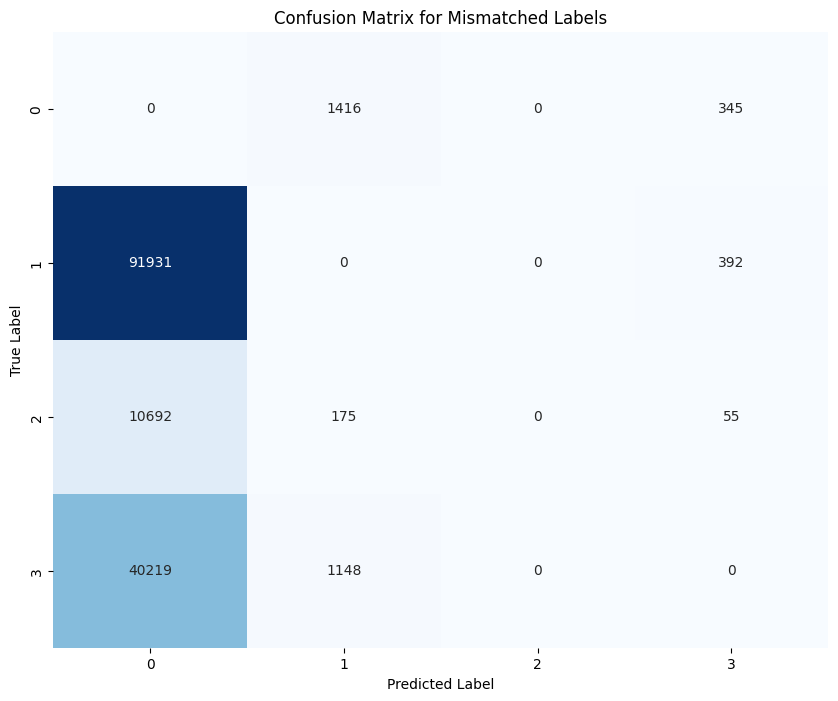

In [34]:
conf_matrix = confusion_matrix(mismatch_df['true_label'], mismatch_df['predicted_label'])

labels = sorted(mismatch_df['true_label'].unique())  
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Mismatched Labels')
plt.show()

In [38]:
# finding the top 15 queries where true label is 3 but predicted is 0
specific_mismatch_df = mismatch_df[(mismatch_df['true_label'] == 3) & (mismatch_df['predicted_label'] == 0)]
top_15_queries = specific_mismatch_df[['query', 'product_title']].head(15)
print(top_15_queries)

                           query  \
32  !qscreen fence without holes   
33  !qscreen fence without holes   
37  !qscreen fence without holes   
38  !qscreen fence without holes   
40  !qscreen fence without holes   
43  !qscreen fence without holes   
44  !qscreen fence without holes   
46  !qscreen fence without holes   
47  !qscreen fence without holes   
48  !qscreen fence without holes   
49  !qscreen fence without holes   
50  !qscreen fence without holes   
52  !qscreen fence without holes   
54  !qscreen fence without holes   
57  !qscreen fence without holes   

                                        product_title  
32  FOTMISHU 6Pcs Greenhouse Hoops Rust-Free Grow ...  
33  Zippity Outdoor Products ZP19028 Unassembled M...  
37  MIXC 10-Pack Seed Trays Seedling Starter Tray,...  
38  CandyHome Green Anti Bird Protection Net Mesh ...  
40  EasyBaby Products Indoor Outdoor Retractable B...  
43  DearHouse Artificial Ivy Privacy Fence Screen,...  
44  (10 Pack) Vinyl Siding Clip